# Imports

In [7]:
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
import pandas as pd
import bisect 

# Functions

In [ ]:
"""
        ???
        
        PARAMS:
        array Obj     Object in Simulation
        array U       Prey Density
        array V       Predator Density
        
        RETURNS:
        arrays nn_array and neighbours
        
"""
"""
        Calculate F from formula 2
        
        PARAMS:
        array U       Prey Density
        array V       Predator Density
        float Alpha   Fixed parameter
        float Beta    
        float Gamma 
        
        
        RETURNS:
        array of F
        
"""

In [19]:
@njit
def init_arrays(N):
    """
        Create initial arrays
        
        PARAMS:
        int N       Size of the grid
        
        RETURNS:
        arrays of size(N,N):
            - F, G, L_U and L_V with 0
            - U filled with 1
            - V 0 with 3 starting values
        
    """
    U = np.ones((N, N))#np.random.rand(N, N)
    V = np.zeros((N, N))
    V[N//2-10 : N//2+10, N//2-10 : N//2+10] = 5
    V[N//5:N//5 + N//10, N//2:N//2 + N//10] = 5
    V[N//2:N//2 + N//10, N//2:N//2 + N//10] = 5
    F = np.zeros((N, N))
    G = np.zeros((N, N))
    L_U = np.zeros((N, N)) 
    L_V = np.zeros((N, N)) 
    return U, V, F, G, L_U, L_V

@njit()
def get_F(U, V, alpha, beta, gamma):
    """
        Calculate F from formula 2
        
        PARAMS:
        array U       Prey Density
        array V       Predator Density
        float Alpha   Fixed parameter
        float Beta    ???
        float Gamma   ???
        
        
        RETURNS:
        array of F
        
    """
    return alpha * U * ((1 - U) - (V / (1 + beta * U)))

@njit
def get_G(U, V, alpha, beta, gamma):
    """
        Calculate G from formula 2
        
        PARAMS:
        array U       Prey Density
        array V       Predator Density
        float Alpha   Fixed parameter
        float Beta    ???
        float Gamma   ???
        
        
        RETURNS:
        array of G
        
    """
    return V * (beta * U / (1 + beta * U) - gamma)

def get_neighbors(Ob, U, V):
    """
        ???
        
        PARAMS:
        array Obj     Object in Simulation
        array U       Prey Density
        array V       Predator Density
        
        RETURNS:
        arrays nn_array and neighbours
        
    """
    neighbors = np.zeros((N, N, 4, 2), np.int)
    neighbors[:, :, :, :] = -1
    
    nn_numbers = np.zeros((N, N), dtype = np.int)
    for i in range(N):
        for j in range(N):
            if Ob[i, j] == True:
                U[i, j] = 0
                V[i, j] = 0
            else: 
                if not Ob[(i + 1) % N, j]:
                    neighbors[i, j, nn_numbers[i, j], 0] = (i + 1) % N 
                    neighbors[i, j, nn_numbers[i, j], 1] = j
                    nn_numbers[i, j] += 1
                if not Ob[(i - 1) % N, j]:
                    neighbors[i, j, nn_numbers[i, j], 0] = (i - 1) % N
                    neighbors[i, j, nn_numbers[i, j], 1] = j
                    nn_numbers[i, j] += 1
                if not Ob[i, (j + 1) % N]:
                    neighbors[i, j, nn_numbers[i, j], 0] = i 
                    neighbors[i, j, nn_numbers[i, j], 1] = (j + 1)  % N
                    nn_numbers[i, j] += 1
                if not Ob[i, (j - 1) % N]:
                    neighbors[i, j, nn_numbers[i, j], 0] = i 
                    neighbors[i, j, nn_numbers[i, j], 1] = (j - 1)  % N
                    nn_numbers[i, j] += 1
                    
    return neighbors, nn_numbers

@njit
def get_laplacian_with_object(D_U, U, L_U, nn_array, nn_numbers):
    """
        Fills L_U with the Laplacian with object
        
        PARAMS:
        float D_U          Diffusion Constant Prey
        array U            Prey Density
        array L_U          Laplacian of Prey
        array nn_array     ???
        array nn_numbers   ???
        
        RETURNS:
        -
        
        CHANGES:
        Fills L_U 
        
    """
    
    C = D_U/dx**2
    for i in range(0, N):
        for j in range(0, N):
            L_U[i, j] = 0 
            for k in range(nn_numbers[i, j]):
                neigh_x, neigh_y = nn_array[i, j, k]
                L_U[i, j] += U[neigh_x, neigh_y]
            L_U[i, j] -= nn_numbers[i, j] * U[i, j]
            L_U[i, j] * C

@njit
def get_circle(R, displacement_x, displacement_y):
    """
        Makes object (circle) array
        
        PARAMS:
        int R                      Radius of the circle
        int displacement_x         displacement on the x-axis
        int displacement_y         displacement on the y-axis
        
        RETURNS:
        array obj with True indicates it is in the object
 
    """
    obj = np.zeros((N, N))    
    for i in range(N):
        for j in range(N):
            obj[i, j] = (i- N//2 - displacement_x)**2 + (j- N//2 - displacement_y)**2 < R**2
    return obj

@njit
def get_laplacian(D_U, U, L_U):
    """
        Fills L_U with the Laplacian
        
        PARAMS:
        float D_U          Diffusion Constant Prey
        array U            Prey Density
        array L_U          Laplacian of Prey
        
        RETURNS:
        -
        
        CHANGES:
        Fills L_U 
        
    """
    C = D_U/dx**2
    for i in range(0, N):
        for j in range(0, N):
            L_U[i, j] = C * (U[(i + 1) % N, j]+U[(i - 1 + N) % N, j]+U[i, (j + 1) % N]+ U[i, (j - 1 + N) % N]- 4*U[i, j])
    

@njit
def update(A, F_A, L_A, dt):
    """
    Updates a function A where F_A is the updating function of A
    and L_A is the Laplacian of A

    PARAMS:
    array A            Prey/Predator Density
    array F_A          ???
    array L_A          Laplacian of Prey
    float dt           Stepsize

    RETURNS:
    A        
    """
    A += dt * (F_A + L_A)
    return A

@njit

def do_iter_diffusion_object(U, V, F, G, L_U, L_V, D_U, D_V, alpha, beta, gamma, dt, dx, nn, nn_numbers, data_array = None, i = None):
    # Initialize concentration matrix c(x,y;t)
    """
        ???
        
        PARAMS:
        array U               Prey Density
        array V               Predator Density
        array F               ???
        array G.              ???
        array L_U             Laplacian Prey
        array L_V             Laplacian Predator
        float D_U             Diffusion Coefficient Prey
        float D_V             Diffusion Coefficient Predator
        float Alpha           Fixed Parameter
        float Beta            ???
        float Gamma           ???
        float dt              timestep
        float dx.             never used ???
        array nn              ???
        array nn_numbers      ???
        array data_array      ???
        
        RETURNS:
        -
        
        CHANGES:
        F,U,U,V and data_array
 
    """
    F = get_F(U, V, alpha, beta, gamma)
    G = get_G(U, V, alpha, beta, gamma)
    get_laplacian_with_object(D_U, U, L_U, nn, nn_numbers)
    get_laplacian_with_object(D_V, V, L_V, nn, nn_numbers)
    U = update(U, F, L_U, dt)
    V = update(V, G, L_V, dt)
    if data_array != None:
        data_array[i, 0] = np.mean(U)
        data_array[i, 1] = np.mean(V)

@njit
def do_iter_diffusion(U, V, L_U, L_V, D_U, D_V, alpha, beta, gamma, dt, dx, data_array = None, i = None):
    # Initialize concentration matrix c(x,y;t)
    #copy from above
    F = get_F(U, V, alpha, beta, gamma)
    G = get_G(U, V, alpha, beta, gamma)
    get_laplacian(D_U, U, L_U)
    get_laplacian(D_V, V, L_V)
    U = update(U, F, L_U, dt)
    V = update(V, G, L_V, dt)
    if data_array != None:
        data_array[i, 0] = np.mean(U)
        data_array[i, 1] = np.mean(V)
    
def mkdir_p(mypath):
    """
        Checks and/or creates directory 
        
        PARAMS:
        string mypath       directory
        
        RETURNS:
        -
        
        CHANGES:
        Can create the given directory
        
    """

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

# Create new directory
def explore_colormaps(U, V):
    """
        ???
    """
    p =  plt.colormaps()
    output_dir = "data/colormaps"
    mkdir_p(output_dir)

    for color in p:
        make_fig(U, V, color, 100, output_dir)
        
def make_fig(U, V, color = 'viridis', dpi = 500, output_dir = 'data',fs=14):
    """
        Makes very bueno plots
        
        PARAMS:
        array U               Prey Density
        array V               Predator Density
        string color          Fixed parameter
        int dpi               Dpi for the save
        string output_dir     Output directory
        int fs                Fontsize
        
        
        RETURNS:
        Saves figure
        
        
    """
    
    global R, displacement_x, displacement_y
    fig, axes = plt.subplots(1, 3, figsize = (17.5,5))
    axes[0].plot(data_array[:, 0], label = 'U')
    axes[0].plot(data_array[:, 1], label = 'V')
    axes[0].set_xlabel("Iterations", fontsize=fs)
    axes[0].set_ylabel("Populations", fontsize=fs)
    axes[0].set_title("Populations over Time", fontsize=fs+2)
    axes[0].grid()
    axes[0].legend()
    
    im1 = axes[1].imshow(U, origin = "Bottom", cmap = plt.get_cmap(color), aspect="auto")
    divider1 = make_axes_locatable(axes[1])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im1, cax=cax1)
    axes[1].set_title('Prey Density (U)',fontsize=fs+2)
    axes[1].axis('off')
    axes[1].grid()

    im2 = axes[2].imshow(V, origin = "Bottom", cmap = plt.get_cmap(color), aspect="auto")
    divider2 = make_axes_locatable(axes[2])
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im2, cax=cax2)
    axes[2].set_title('Predator Density (V)',fontsize=fs+2)
    axes[2].axis('off')
    
    plt.show()
#     plt.savefig(f'{output_dir}/N_{N}_Nit_{Nit}_a_{alpha}_b_{beta}_c_{gamma}_DU_{D_U}_DV_{D_V}_dt_{dt}_cmap_{color}.png', dpi = dpi)
    plt.show()
    plt.clf()

def make_fig_object(U, V, color = 'viridis', dpi = 500, output_dir = 'data',fs=14):
    """
        Makes very bueno plots with object
        
        PARAMS:
        array U               Prey Density
        array V               Predator Density
        string color          Fixed parameter
        int dpi               Dpi for the save
        string output_dir     Output directory
        int fs                Fontsize
        
        
        RETURNS:
        Saves figure
        
        
    """
    
    global R, displacement_x, displacement_y
    fig, axes = plt.subplots(1, 3, figsize = (17.5,5))
    axes[0].plot(data_array[:, 0], label = 'U')
    axes[0].plot(data_array[:, 1], label = 'V')
    axes[0].set_xlabel("Iterations", fontsize=fs)
    axes[0].set_ylabel("Populations", fontsize=fs)
    axes[0].set_title("Populations over Time", fontsize=fs+2)
    axes[0].grid()
    axes[0].legend()
    
    x_ar,y_ar = np.where(get_circle(R, displacement_x, displacement_y)==1)
    
    im1 = axes[1].imshow(U, origin = "Bottom", cmap = plt.get_cmap(color), aspect="auto")
    axes[1].scatter((y_ar[-1]+y_ar[0])/2,(x_ar[-1]+x_ar[0])/2, s=np.pi*R**2,c="white")
    divider1 = make_axes_locatable(axes[1])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im1, cax=cax1)
    axes[1].set_title('Prey Density (U)',fontsize=fs+2)
    axes[1].axis('off')
    axes[1].grid()

    im2 = axes[2].imshow(V, origin = "Bottom", cmap = plt.get_cmap(color), aspect="auto")
    axes[2].scatter((y_ar[-1]+y_ar[0])/2,(x_ar[-1]+x_ar[0])/2, s=np.pi*R**2,c="white")
    divider2 = make_axes_locatable(axes[2])
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im2, cax=cax2)
    axes[2].set_title('Predator Density (V)',fontsize=fs+2)
    axes[2].axis('off')
    
    plt.show()
#     plt.savefig(f'{output_dir}/N_{N}_Nit_{Nit}_a_{alpha}_b_{beta}_c_{gamma}_DU_{D_U}_DV_{D_V}_dt_{dt}_cmap_{color}.png', dpi = dpi)
    plt.show()
    plt.clf()

## Images

### Without Object

100%|██████████| 20000/20000 [00:20<00:00, 975.06it/s] 


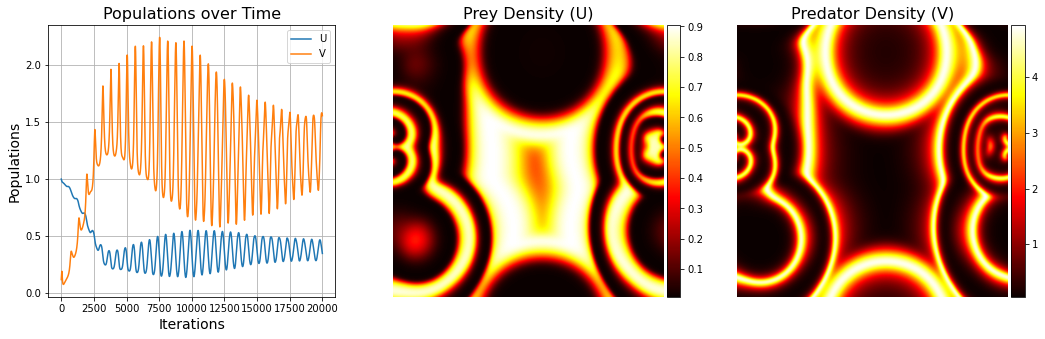

<Figure size 432x288 with 0 Axes>

In [14]:
# Running
N = 300
dx = 400/N
U, V, F, G, L_U, L_V = init_arrays(N)
D_U = 0.01
D_V = 1
alpha = 0.5
beta = 5
gamma = 0.5
dt = 0.05

output_dir = "data"
Nit = 20000
data_array = np.zeros((Nit, 2))

fps = 5
nSeconds = 20

for i in tqdm(range(Nit)):
    do_iter_diffusion(U, V, F, G, L_U, L_V, D_U, D_V, alpha, beta, gamma, dt, dx,data_array,i)

make_fig(U, V,color='hot')

### With Object

100%|██████████| 20000/20000 [05:11<00:00, 64.19it/s]


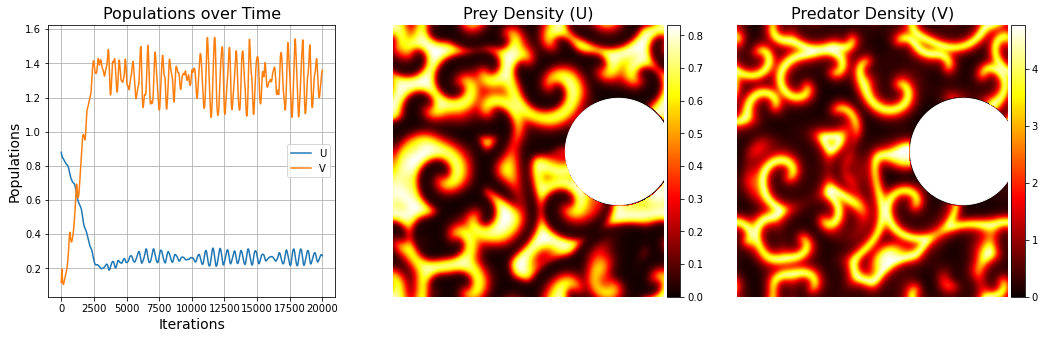

<Figure size 432x288 with 0 Axes>

In [6]:
# Running
N = 300
dx = 400/N
U, V, F, G, L_U, L_V = init_arrays(N)
D_U = 0.01
D_V = 1
alpha = 0.5
beta = 5
gamma = 0.5
dt = 0.05

output_dir = "data"
Nit = 20000
data_array = np.zeros((Nit, 2))

fps = 5
nSeconds = 20

R, displacement_x, displacement_y = 60, 10,100
obj = get_circle(R, displacement_x, displacement_y)
nn, nn_numbers = get_neighbors(obj, U, V)
for i in tqdm(range(Nit)):
    do_iter_diffusion_object(U, V, L_U, L_V, D_U, D_V, alpha, beta, gamma, dt, dx, nn, nn_numbers, data_array, i)

make_fig_object(U, V,color='hot')

## Videos

### Without Object

### With Object

# Phase Diagram

<ipython-input-5-65a772bd65db>:2: RuntimeWarning: divide by zero encountered in true_divide
  beta0 = gamma/(1-gamma)
<ipython-input-5-65a772bd65db>:3: RuntimeWarning: divide by zero encountered in true_divide
  beta1 = (1+gamma)/(1-gamma)
<ipython-input-5-65a772bd65db>:18: RuntimeWarning: divide by zero encountered in true_divide
  line0 = plt.plot(gamma_plot, gamma_plot/(1-gamma_plot), label=r"$\beta_0$", color="tab:blue")
<ipython-input-5-65a772bd65db>:19: RuntimeWarning: divide by zero encountered in true_divide
  line1 = plt.plot(gamma_plot, (1+gamma_plot)/(1-gamma_plot), label=r"$\beta_1$", color="tab:orange")
<ipython-input-5-65a772bd65db>:20: RuntimeWarning: divide by zero encountered in true_divide
  line2 = plt.plot(gamma_plot, (1+2*gamma_plot)/(2*(1-gamma_plot)), label=r"$\frac{\beta_0+\beta_1}{2}$", color="tab:red")


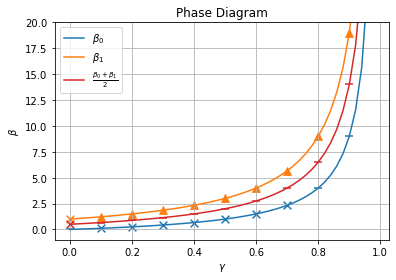

In [5]:
#Values for which plots are made
gamma = np.linspace(0,1,11)
beta0 = gamma/(1-gamma)
beta1 = (1+gamma)/(1-gamma)
beta2 = (beta1 + beta0)/2

#From the plots
values0 = np.array(["eq","ex","ex","ex","ex","ex","ex","ex","eq","eq","nan"])
values1 = np.array(["ex","osc","osc","osc","osc","osc","osc","osc","osc","osc","nan"])
values2 = np.array(["ex","eq","eq","eq","eq","eq","eq","eq","eq","eq","nan"])
colors = ["tab:blue","tab:orange", "tab:red"]

beta = np.array([beta0,beta1,beta2])
values = np.array([values0,values1,values2])
types = ["eq","ex","nan","osc"]
markers = ["_","x","d","^"]


#Plotting
gamma_plot = np.linspace(0,1,51)

line0 = plt.plot(gamma_plot, gamma_plot/(1-gamma_plot), label=r"$\beta_0$", color="tab:blue")
line1 = plt.plot(gamma_plot, (1+gamma_plot)/(1-gamma_plot), label=r"$\beta_1$", color="tab:orange")
line2 = plt.plot(gamma_plot, (1+2*gamma_plot)/(2*(1-gamma_plot)), label=r"$\frac{\beta_0+\beta_1}{2}$", color="tab:red")

for i in range(3):
    for j in range(4):
        plt.scatter(gamma[values[i]==types[j]],beta[i][values[i]==types[j]],c=colors[i],marker=markers[j],s=60)
    
plt.grid()

legend1 = plt.legend(loc=0)
plt.ylim(-1,20)
plt.title("Phase Diagram")
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\beta$")
plt.show()

# Complexity Plot